# Get the Divers data of Leiduin

Amsterdam Water Supply Dunes

TO 2025-02-09

In [43]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.interpolate import CubicSpline
from collections.abc import Iterable   # import directly from collections for Python < 3.3

In [2]:
def AND(seq):
    """Return logical and of a sequence of logical arrays."""
    L = seq[0]
    for s in seq:
        L = np.logical_and(L, s)
    return L

In [3]:
dtype = np.dtype([('dt', 'datetime64[s]'), ('v', float)])

In [4]:
def gw2rd(GWxy, verbose=False):
    """Return RD coordinates given GW coordinates.

    RD is then Dutch national triangulized coordinates system.
    GW is Gemeentewaterleidingen (Amsterdam Water Supply Dunes system, which is perpendiular
        to the coast line along the Amstedam Water Supply Dunes with zero x at the beach, i.e.
        the distance from the coast.

    Parameters
    ----------
    GWxy: array (n, 2) of floats
        GW coofdinates

    Returns
    -------
    RDxy: np.array (n, 2) of floats
        RD coordinates

    >>>gw2rd(np.array([[61892.94, 885.364]]))
    array([[155000, 463000]])

    See also
    --------
    rd2gw wgs2rd rd2wgs

    @ Pierre Kamps 1999-11-10,
    @ TO 2024-02-10
    """
    assert GWxy.shape[1] == 2, 'RDxy must have shape(n, 2), not {}'.format(shape(RDxy))

    GWaugT = np.ones((3, GWxy.shape[0]))
    GWaugT[:2, :] = GWxy.T

    angle = 22.58378 * np.pi / 180
    xca, yca  =  155000.0, 463000.0
    xrn, yrn  =  -57486.9,  22951.5

    dx, dy = xrn + xca, yrn + yca

    M = np.array([[ np.cos(angle), np.sin(angle), dx],
                  [-np.sin(angle), np.cos(angle), dy],
                  [             0,             0,  1]])
    if verbose:
        print('M = \n', M)
    
    RDxy = (M @ GWaugT).T[:, :2]

    return RDxy


def rd2gw(RDxy, verbose=False):
    """Return GW coordinates given RD coordinates.

    RD is then Dutch national triangulized coordinates system.
    GW is Gemeentewaterleidingen (Amsterdam Water Supply Dunes system, which is perpendiular
        to the coast line along the Amstedam Water Supply Dunes with zero x at the beach, i.e.
        the distance from the coast.

    Parameters
    ----------
    RDxy: array (n, 2) of floats
        RD coofdinates

    Returns
    -------
    GWxy: np.array (n, 2) of floats
        GW coordinates


    >>>rd2gw(np.array([[155000, 463000]]))
    np.array([[61892.94, 885.364]])

    See also
    --------
    gw2rd wgs2rd rd2wgs

    @ Pierre Kamps 1999-11-10, 
    @ TO 2024-02-10
    """
    assert RDxy.shape[1] == 2, 'RDxy must have shape(n, 2), not {}'.format(shape(RDxy))

    RDaugT = np.ones((3, RDxy.shape[0]))
    RDaugT[:2, :] = RDxy.T

    angle = 22.58378 * np.pi / 180
    xca, yca  =  155000.0, 463000.0
    xrn, yrn  =  -57486.9,  22951.5

    dx, dy = xrn + xca, yrn + yca

    M = np.array([[ np.cos(angle), np.sin(angle), dx],
                  [-np.sin(angle), np.cos(angle), dy],
                  [             0,             0,  1]])
    if verbose:
        print('np.linalg.inv(M) = \n', np.linalg.inv(M))
    
    GWxy = (np.linalg.inv(M) @ RDaugT).T[:, :2]

    return GWxy

#gw = np.array([[ 61892.94,    885.364]])
#print(rd2gw(gw2rd(gw)))

#rd = np.array([[155000.04, 463000.000]])
#print(gw2rd(rd2gw(rd)))

In [5]:
def mlDatenum2npDatetime(mlDatenum):
    """Return np.Datenum64(object) from matlab datenum.

    >>>739291.4753587963
    np.datetime64('2023-02-09 11:24:31')
    """
    unix_start_datetime = np.datetime64('1970-01-01')
    unix_start_datenum = 719529
    return (unix_start_datetime
            + (mlDatenum - unix_start_datenum) * 86400 * np.timedelta64(1, 's'))


def npDatetime2mlDatenum(datetime):
    """Return matlab datenum from np.Datenum64 object.

    >>>npDatetime642mlDatenum(np.datetime64('2023-02-09 11:24:31'))
    739291.4753587963
    """
    unix_start_datetime = np.datetime64('1970-01-01')
    unix_start_datenum = 719529
    return ((datetime - unix_start_datetime)
            / np.timedelta64(1, 's') / 86400 + unix_start_datenum)

print(npDatetime2mlDatenum(np.datetime64('2023-02-09 11:24:31')))
print(mlDatenum2npDatetime(738926.4753587963))

# Shorthand
dn2dt = mlDatenum2npDatetime
dt2dn = npDatetime2mlDatenum

738926.4753587963
2023-02-09T11:24:31


# Read Divers_Leiduin.mat using mat file using scipy.io.loadmat(f)

In [6]:
HOME = '/Users/Theo/GRWMODELS/AWD/PeilData/'
f = os.path.join(HOME, 'Divers_Leiduin.mat')

In [7]:
diversLDN = loadmat(f)

### All relevant data are under key 'H'

In [8]:
diversLDN.keys()

dict_keys(['__header__', '__version__', '__globals__', 'H', 'IN', 'M', 'B', 'T', 'ID', 'VER'])

### The first date set has items pertaining to the Barometer at Leiduin

In [9]:
# Has data of saving (kind of version specification)
diversLDN['VER']

array([[array([[array(['2'], dtype='<U1'), array(['x'], dtype='<U1'),
                array(['c.w'], dtype='<U3'), array(['(beta)'], dtype='<U6')]],
              dtype=object)                                                   ,
        array(['12 September 2012'], dtype='<U17')]], dtype=object)

In [10]:
# Tells the number of items in the file in fields H, IN, M, B
diversLDN['ID']

array([[(array([[418]], dtype=uint16), array([[19]], dtype=uint8), array([[0]], dtype=uint8), array([[0]], dtype=uint8))]],
      dtype=[('H', 'O'), ('IN', 'O'), ('M', 'O'), ('B', 'O')])

In [11]:
diversLDN['B']

array([], shape=(0, 1),
      dtype=[('ID', 'O'), ('name', 'O'), ('xcoord', 'O'), ('ycoord', 'O'), ('surflev', 'O'), ('date', 'O'), ('soillayers', 'O')])

In [12]:
# Defines time sampling
diversLDN['M']

array([], shape=(0, 1),
      dtype=[('ID', 'O'), ('name', 'O'), ('tdiscr', 'O'), ('equid', 'O'), ('nonlin', 'O'), ('resamph', 'O'), ('startup', 'O'), ('lockpar_yn', 'O'), ('lockedpar', 'O'), ('xcoord', 'O'), ('ycoord', 'O'), ('zcoord', 'O'), ('h', 'O'), ('result', 'O'), ('noise', 'O'), ('in', 'O')])

In [13]:
print("Number of peilbuizen in diversLDN['H'] = {}".format(len(diversLDN['H'])))

pbuis = dict()
for item in diversLDN['H']:
    data = item[0]
    name = data[1][0]
    pbuis[name] = {
        'id': data[0][0][0],
        'name': name,
        'values': data[3],
        'xRD': data[5][0][0],
        'yRD': data[6][0][0],
        'bkf': data[7][0][0],
        'okf': data[8][0][0],
        'mv': data[9][0][0],
        }

Number of peilbuizen in diversLDN['H'] = 418


# Show PREC and EVAP series DW['IN']

In [14]:
print("Number of items in diversLDN['IN'] = {}".format(len(diversLDN['IN'])))

rm = dict()
for item in diversLDN['IN']:
    data = item[0]
    id = data[0][0][0]
    rm[id] = {
        'id': id,
        'name': data[1][0],
        'type': data[2][0],
        'values': data[3],
        'xRD': data[4][0][0],
        'yRD': data[5][0][0],
        }
rm

Number of items in diversLDN['IN'] = 19


{1: {'id': 1,
  'name': 'RM01',
  'type': 'PREC',
  'values': array([[7.24488e+05, 1.18000e-02],
         [7.24495e+05, 6.80000e-03],
         [7.24502e+05, 7.00000e-04],
         ...,
         [7.35219e+05, 2.41000e-02],
         [7.35226e+05, 4.12000e-02],
         [7.35233e+05, 2.61000e-02]]),
  'xRD': 93899.9,
  'yRD': 480740},
 2: {'id': 2,
  'name': 'RM02',
  'type': 'PREC',
  'values': array([[7.24488e+05, 1.21000e-02],
         [7.24495e+05, 5.20000e-03],
         [7.24502e+05, 8.00000e-04],
         ...,
         [7.35219e+05, 2.54000e-02],
         [7.35226e+05, 4.30000e-02],
         [7.35233e+05, 2.72000e-02]]),
  'xRD': 94350,
  'yRD': 480610},
 3: {'id': 3,
  'name': 'RM03',
  'type': 'PREC',
  'values': array([[7.24488e+05, 1.00000e-02],
         [7.24495e+05, 5.20000e-03],
         [7.24502e+05, 7.00000e-04],
         ...,
         [7.35219e+05, 2.39000e-02],
         [7.35226e+05, 4.10000e-02],
         [7.35233e+05, 2.60000e-02]]),
  'xRD': 95369.7,
  'yRD': 480585},


# Get the barometer of Leiduin data

In [15]:
f = os.path.join(HOME, 'Ldruk_leiduin_20140408.mat')
Baro = loadmat(f)
for item in Baro['IN'][0][0]:
    print(item)



['BARO_LEIDUIN.0']
['BARO_LEIDUIN.0']
[[728808.66666667   1038.0035796 ]
 [728808.70833333   1037.004254  ]
 [728808.75         1037.004254  ]
 ...
 [735696.91666667   1026.96001132]
 [735696.95833333   1026.55212315]
 [735697.           1026.04226383]]
[[96000]]
[[485000]]
['BARO']
[]
[]
[]
[]


In [16]:
b = Baro['IN'][0][0]

times = b[2][:, 0]
interval = np.median(np.diff(times))
baro = {
        'name': 'baroLDN',
        'xRD': b[3][0][0],
        'yRD':b[4][0][0],
        'N': len(b[2]),
        'days': times[-1] - times[0], #  / times must be datenums
        'intervalMin': np.round(interval * 24 * 60, 0),        
        'tstrt': mlDatenum2npDatetime(times[0]),
        'tend': mlDatenum2npDatetime(times[-1]),
        'values': b[2],
    }
baro

{'name': 'baroLDN',
 'xRD': 96000,
 'yRD': 485000,
 'N': 164590,
 'days': 6888.333333333372,
 'intervalMin': 60.0,
 'tstrt': numpy.datetime64('1995-05-29T15:59:59'),
 'tend': numpy.datetime64('2014-04-08T00:00:00'),
 'values': array([[728808.66666667,   1038.0035796 ],
        [728808.70833333,   1037.004254  ],
        [728808.75      ,   1037.004254  ],
        ...,
        [735696.91666667,   1026.96001132],
        [735696.95833333,   1026.55212315],
        [735697.        ,   1026.04226383]])}

### Show the dataset

In [17]:
pBaro = np.zeros(len(baro['values']), dtype=dtype)
pBaro['dt'] = mlDatenum2npDatetime(baro['values'][:, 0])
pBaro['v']  = baro['values'][:, 1]
pBaro

array([('1995-05-29T15:59:59', 1038.0035796 ),
       ('1995-05-29T17:00:00', 1037.004254  ),
       ('1995-05-29T18:00:00', 1037.004254  ), ...,
       ('2014-04-07T21:59:59', 1026.96001132),
       ('2014-04-07T23:00:00', 1026.55212315),
       ('2014-04-08T00:00:00', 1026.04226383)],
      dtype=[('dt', '<M8[s]'), ('v', '<f8')])

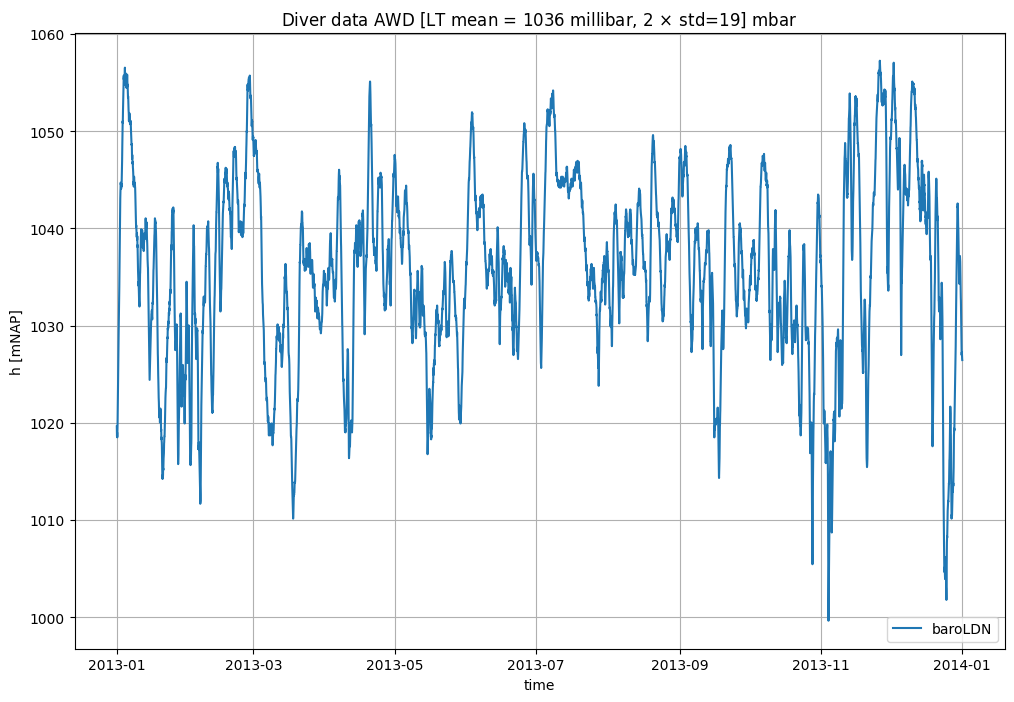

In [18]:
def plot_baro(baro, tlim=None):
    """Plot the barometer (station Leiduin) for given time range tlim.

    Parameters
    ----------
    baro: the dataset, np.ndarray(n, 2) of (matlabdatenum, mbar)
        barometer pressure time series
    tlim: (datetime64(tstart), datetime64(tend))
    """
    tb = baro['values'][:, 0]
    pb = baro['values'][:, 1]
    L = np.logical_and(tb >= dt2dn(tlim[0]), tb <= dt2dn(tlim[1]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.set_title(r'Diver data AWD [LT mean = {:.0f} millibar, 2$\,\times\,$std={:.0f}] mbar'.format(pb[L].mean(), 2 * pb[L].std()))
    ax.set_xlabel('time')
    ax.set_ylabel('h [mNAP]')
    ax.grid(True)
    # ax.set_xlim(np.datetime64('2011-01-01'), np.datetime64('2014-01-01'))

    plt.plot(dn2dt(tb[L]), pb[L], label=baro['name'])

    ax.legend(loc='lower right')

    fig.savefig("baroLeiduin.png")

    plt.show()

tlim = (np.datetime64('2013-01-01'), np.datetime64('2014-01-01'))
plot_baro(baro, tlim=tlim)

In [19]:
# Investigate 24H378
for name in [k for k in pbuis if k.startswith('24H378')]:
    print(pbuis[name])
    print()

{'id': 151, 'name': '24H378.1', 'values': array([[7.32008750e+05, 6.63000000e-01],
       [7.32008792e+05, 6.53000000e-01],
       [7.32008833e+05, 6.52000000e-01],
       ...,
       [7.35696917e+05, 6.08000000e-01],
       [7.35696958e+05, 5.99000000e-01],
       [7.35697000e+05, 5.94000000e-01]]), 'xRD': 95468.36, 'yRD': 480829.4, 'bkf': -26.2, 'okf': -27.2, 'mv': 6.8}

{'id': 152, 'name': '24H378.3', 'values': array([[7.28983750e+05, 1.87200000e+00],
       [7.28984000e+05, 1.88200000e+00],
       [7.28984250e+05, 1.89700000e+00],
       ...,
       [7.35679292e+05, 3.14900000e+00],
       [7.35679333e+05, 3.15000000e+00],
       [7.35679375e+05, 3.15400000e+00]]), 'xRD': 95468.36, 'yRD': 480829.4000000001, 'bkf': -2.2, 'okf': -3.2, 'mv': 6.8}

{'id': 153, 'name': '24H378.4', 'values': array([[7.29043500e+05, 4.84700000e+00],
       [7.29043750e+05, 4.85300000e+00],
       [7.29044000e+05, 4.83800000e+00],
       ...,
       [7.35679333e+05, 6.22500000e+00],
       [7.35679375e+05,

The heads in the diver series have been corrected for the barometer pressure. But this correction only fully works for piezometers in unconfined aquifers. With $p-\overline{b}$ the registered time series and $p - \overline{b} - \Delta b$ the barometer corrected one we obtain for the head in the unconfined aquifer $h$ and in the (semi)confined aquifer $\phi$ respectively

$$ h = z -\frac{p-\overline{b} - \Delta b}{\rho g}$$

and

$$ \phi = z - \frac{p-\overline{b} - \Delta b}{\rho g} - BE \frac{\Delta b}{\rho g} $$

where $BE$ is the barometer efficiency.

# Restoring diver registrations

Assume that the diver is at z = -2 mNAP.
Then h in the pressure is = rho g (h - z) + baro.
rho g = kg/ m2 * N /kg = N /m2 in Pa
the baro is in mbar = cmWK dus do rhog = 100 to convert mwk naar cmwk = mbar

In [25]:
def original_diver_reg(pbuis, pzNames=None, tlim=None):
    """Plot the diver registrations (restored from the head in the database and the baro in the database.

    Parameters
    ----------
    pbuis: the dataset
        piezometer data as a dict
    pzNames: seq. of str
        names of the piezometer (screens)
    tlim: (np.datenum64(tstart), np.datenum64(tend))
        time range
    """
    def mwk2mbar(h):
        return h * 100
    def mbar2mwk(h):
        return h / 100

    zNAP_diver = -5. # assumed elevation of diver logger in piezometer
    
    fig, axs = plt.subplots(len(pzNames) + 1, 1, sharex=True)
    fig.set_size_inches(4.5 * len(pzNames), 8)
    
    for i, name in enumerate(pzNames):
        axs[i].set_title("Logger absolute pressure [mbar]")    
        axs[i].set_ylabel('mbar')
        axs[i].grid(True)
        axs[i].set_xlim(tlim)
        
        t = pbuis[name]['values'][:, 0]
        L = np.logical_and(t >= dt2dn(tlim[0]), t <= dt2dn(tlim[1]))
        t = t[L]
        h = mwk2mbar(pbuis[name]['values'][L, 1] - zNAP_diver)
    
        tb = baro['values'][:, 0]
        Lb = np.logical_and(tb >= dt2dn(tlim[0]), tb <= dt2dn(tlim[1]))
        tb = tb[Lb]
        vb = baro['values'][Lb, 1]
        vb  = np.interp(t, tb, vb)
        
        axs[i].plot(dn2dt(t), h + vb, 'b', label="piezometer {}, screen elevation={:.2f} mNAP".format(name, pbuis[name]['okf']))
            
        axs[i].legend()
    
    i = len(pzNames)
    
    axs[i].set_title("Barometer pressure in mbar")
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('mbar')
    axs[i].grid(True)
    axs[i].plot(dn2dt(tb), vb, 'orange', label="Barometer pressure")
    axs[i].legend()
    
    fig.savefig('pb_and_baro_corr' + pzNames[0][:-2] + 'png')

    plt.show()

In [23]:
def show_pb_with_baro(pbuis, pzNames, tlim=None):
    """Plot corrected heads together with barometer.

    Parameters
    ----------
    pbuis: the dataset
        dictionary with piezometer data
    pzNames: seq. of str
        piezometer names (must be in the dataset
    tlime: (np.datetime64(tstart), np.datetime64(tend)
        tstart and tend of period to analyze.
    """
    fig, axs = plt.subplots(len(pzNames), 1, sharex=True)
    fig.set_size_inches(4 * len(pzNames), 8)
    
    for i, name in enumerate(pzNames):
        axs[i].set_title("(Logged absolute pressure - barometer pressure) / 100 + logger elevation [mNAP] ")
        if i == len(pzNames) - 1:
            axs[i].set_xlabel('date -->')        
        axs[i].set_ylabel('h [mNAP]')
        axs[i].grid(True)
        axs[i].set_xlim(tlim)
        
        t = mlDatenum2npDatetime(pbuis[name]['values'][:, 0])
        L = np.logical_and(t >= tlim[0], t <= tlim[1])
        h = pbuis[name]['values'][L, 1]
        axs[i].plot(t[L], h, 'blue', label="piezometer {}, screen elevation={:.2f} mNAP".format(name, pbuis[name]['okf']))
        
        t = mlDatenum2npDatetime(baro['values'][:, 0])
        L = np.logical_and(t >= tlim[0], t <= tlim[1])
        vb = baro['values'][L, 1] / 100.
        vb = vb - vb.mean() + h.mean()
        
        axs[i].plot(t[L], vb, 'orange', label=r'baro: $ \frac{p_b - \overline{p}_b}{100} + \overline{h}$ [m]')
        axs[i].legend()
    
    fig.savefig('baro_corrected' + pzNames[0][:-2] + 'png')
    
    plt.show()

# Barometer correction only corrects unconfined pressures

# Example of piezometer with large barometer effect.

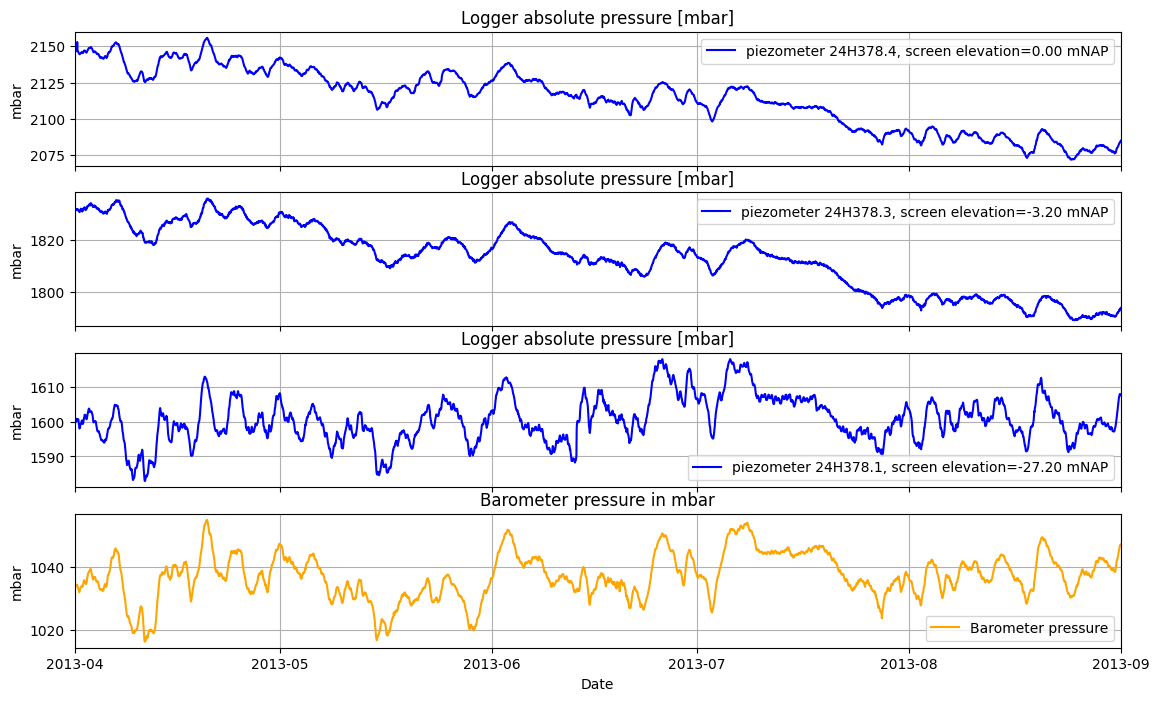

In [26]:
tlim = (np.datetime64('2013-04-01'), np.datetime64('2013-09-01'))
pzNames = ['24H378.4', '24H378.3', '24H378.1']
original_diver_reg(pbuis, pzNames, tlim=tlim)

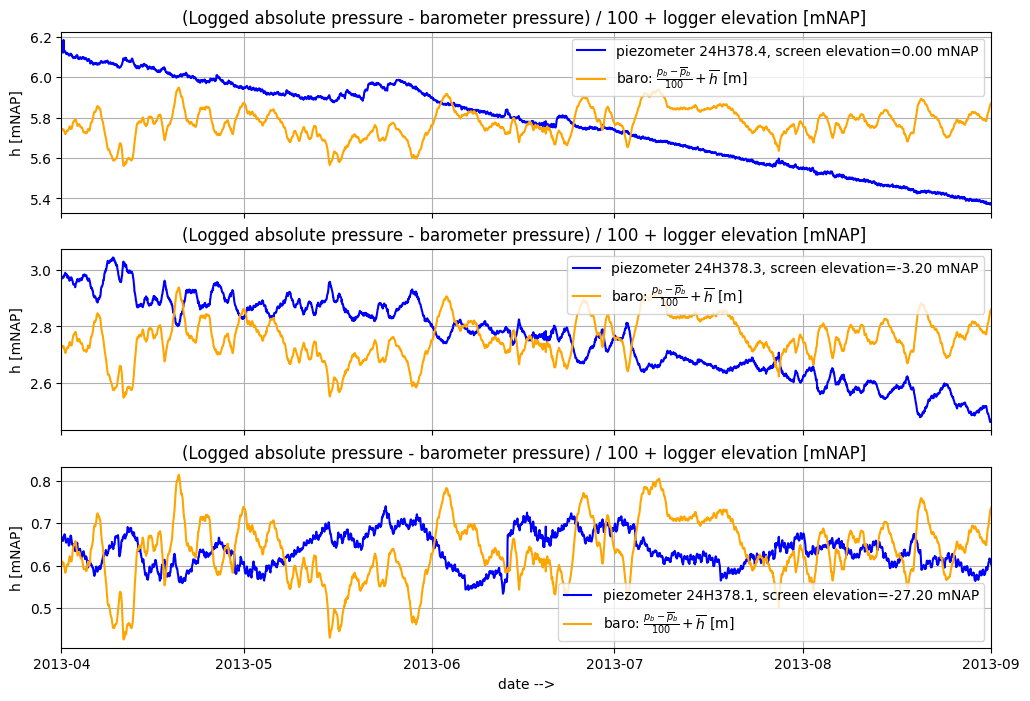

In [27]:
tlim = (np.datetime64('2013-04-01'), np.datetime64('2013-09-01'))
pzNames = ['24H378.4', '24H378.3', '24H378.1']
show_pb_with_baro(pbuis, pzNames, tlim=tlim)

# Importance of Barometer correction

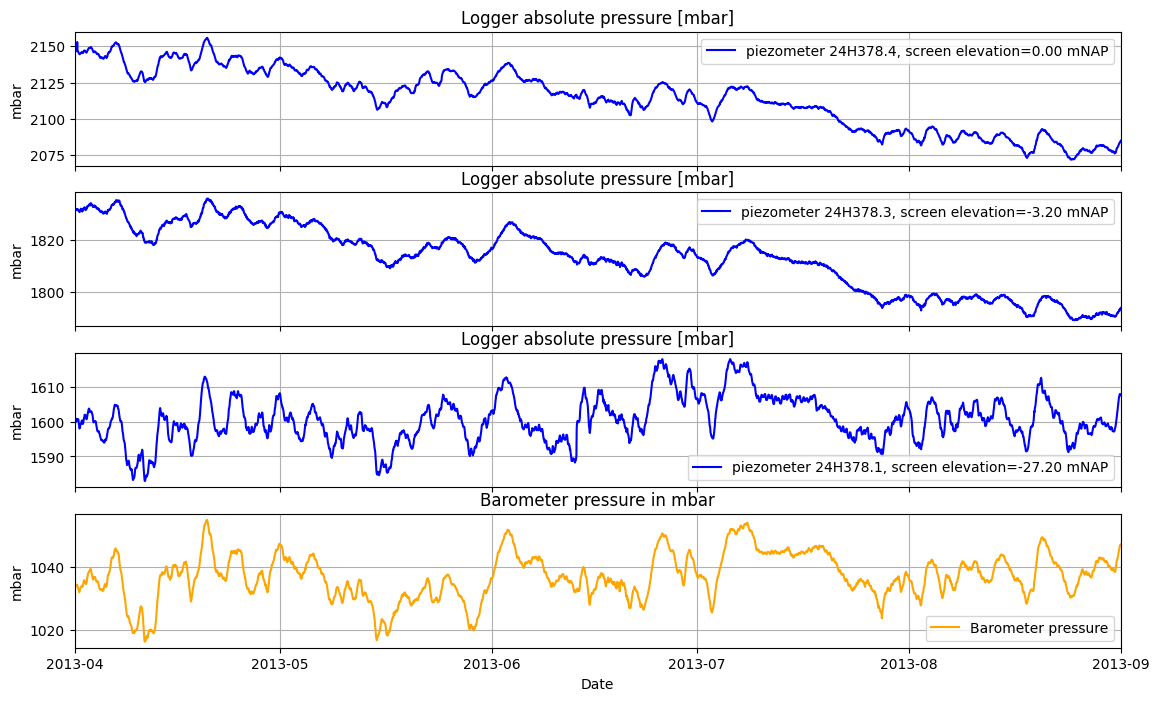

In [28]:
pnames = ['24H717.10', '24H717.7', '24H717.4']    
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-09-01')
original_diver_reg(pbuis, pzNames=pzNames, tlim=tlim)

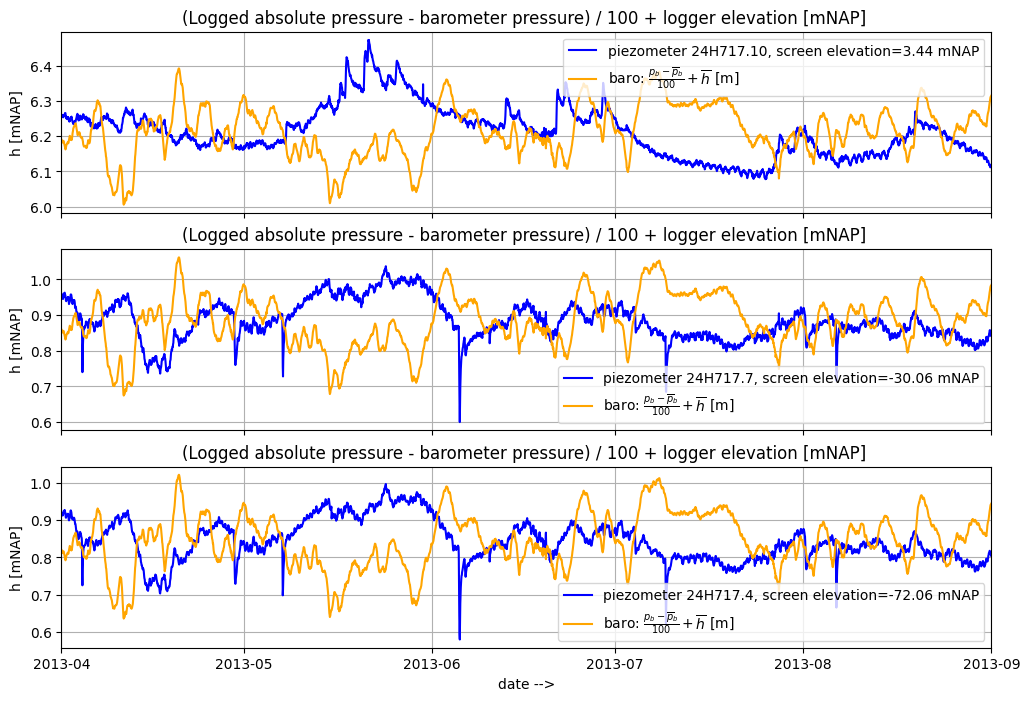

In [29]:
tlim = (np.datetime64('2013-04-01'), np.datetime64('2013-09-01'))
pzNames = ['24H717.10', '24H717.7', '24H717.4']
show_pb_with_baro(pbuis, pzNames, tlim=tlim)

# Well info to DataFrame

In [30]:
columns = ['name', 'xRD', 'yRD', 'xGW', 'yGW', 'dist2sea', 'screenNAP', 'tmin', 'tmax']

def r(v):
    return np.round(v, 2)
    
pbcoords = list()
for name in pbuis:
    p = pbuis[name]
    xRD, yRD = p['xRD'], p['yRD']
    RDxy = np.array([[xRD, yRD]])
    xGW, yGW = rd2gw(np.array([[xRD, yRD]]))[0]
    xGW_beach = -2000
    dist2sea = xGW - xGW_beach
    screenNAP = p['okf']
    t = mlDatenum2npDatetime(p['values'][:, 0])
    tmin, tmax = t[0], t[-1]
    pbcoords.append([name, r(xRD), r(yRD), r(xGW), r(yGW), r(dist2sea), screenNAP, tmin, tmax]) 
    
pbMeta = pd.DataFrame(data=pbcoords, columns=columns, index=[n for n in pbuis]).drop(columns=['name'])
pbMeta

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
10J009.1,99493.79,486211.68,1728.89,1000.88,3728.89,1.2,1999-06-22 11:00:00,2014-03-28 08:00:00
10J011.1,99908.68,485762.30,2284.54,745.29,4284.54,-1.5,2012-04-12 15:00:00,2014-04-07 11:00:00
10J040.1,93129.85,478540.11,-1200.91,-8526.39,799.09,-2.1,2006-11-10 14:00:00,2014-03-03 12:00:00
10J042.1,96433.14,481935.91,544.98,-4122.41,2544.98,-1.9,2009-02-05 20:00:00,2014-04-04 06:59:59
10J044.1,94377.21,479091.10,-260.80,-7538.63,1739.20,-3.1,2006-11-10 14:00:00,2014-03-13 12:00:00
...,...,...,...,...,...,...,...,...
P147.1,96460.84,482232.75,456.56,-3837.70,2456.56,-0.5,2009-02-05 20:00:00,2011-03-30 09:59:59
P152.1,96027.09,484475.52,-805.23,-1933.48,1194.77,-0.5,2002-04-25 15:59:59,2014-03-18 08:00:00
P153.1,95172.20,482282.33,-752.31,-4286.80,1247.69,-0.5,2002-04-25 15:59:59,2014-03-17 12:59:59
P154.1,95536.88,482650.29,-556.91,-3807.00,1443.09,-0.5,2002-11-19 18:00:00,2014-03-17 12:59:59


# Sort out wells for use in tide analysis

In [61]:

L = AND([pbMeta['xGW'] > 1500,
         pbMeta['yGW'] < 2500,
         pbMeta['yGW'] <= -4500,
         pbMeta['yGW'] >= -60000])

pbMeta[L]

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
10J094.1,97130.11,480052.62,1911.75,-5593.63,3911.75,-2.8,2004-03-02 18:00:00,2014-04-04 09:00:00
10J095.1,96946.08,480181.37,1692.39,-5545.43,3692.39,-2,2004-03-02 18:00:00,2014-04-04 09:00:00
10J522.1,97850.06,480512.91,2399.72,-4892.15,4399.72,-5.14,1996-03-15 18:00:00,2005-11-01 12:59:59
10J526.1,97890.00,480410.00,2476.12,-4971.83,4476.12,-1.5,1997-07-10 15:00:00,2002-08-01 09:59:59
10J527.1,97817.99,480469.05,2386.96,-4944.96,4386.96,-6.12,1997-07-10 15:00:00,2002-08-01 09:59:59
10J534.1,97436.98,480925.45,1859.89,-4669.88,3859.89,-8.7,1999-04-16 10:44:59,2000-02-09 09:59:59
10J534.2,97436.98,480925.45,1859.89,-4669.88,3859.89,-4.2,1999-03-01 15:14:59,1999-05-31 09:30:00
24H076.4,97373.34,480597.71,1926.99,-4996.93,3926.99,-85,1997-08-28 03:59:59,1999-02-14 23:00:00
24H076.6,97373.34,480597.71,1926.99,-4996.93,3926.99,-34,1996-08-07 18:00:00,2014-04-08 00:00:00
24H076.7,97373.34,480597.71,1926.99,-4996.93,3926.99,-5,1996-01-19 18:00:00,2014-04-08 00:00:00


# Tides in Groundwater

In [32]:
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')

L = AND([pbMeta['dist2sea'] > 0, pbMeta['dist2sea'] < 2500,
         pbMeta['screenNAP'] <= -25, pbMeta['screenNAP'] >= -50,
         pbMeta['tmax'] > np.datetime64(tlim[0])])

pbMeta[L].sort_values(by=['dist2sea', 'yGW'])

,xRD,yRD,xGW,yGW,dist2sea,screenNAP,tmin,tmax
24H258.5,93920.94,482025.21,-1808.88,-5004.73,191.12,-37.6,2006-11-08 12:00:00,2014-03-27 12:59:59
24H287.5,95149.24,484862.09,-1764.23,-1913.68,235.77,-36.6,2006-11-08 09:59:59,2014-03-27 09:59:59
24H461.5,93301.09,480237.97,-1694.84,-6892.97,305.16,-26.6,2007-03-29 11:00:00,2014-01-05 00:00:00
24H465.4,94843.07,483815.08,-1644.83,-2997.98,355.17,-34.5,1995-05-29 16:15:00,2014-04-08 00:00:00
24H464.5,94482.59,482912.61,-1631.09,-3969.68,368.91,-34.2,1995-05-29 16:44:59,2014-04-08 00:00:00
24H095.1,93497.23,480025.45,-1432.12,-7013.86,567.88,-40,2007-02-20 12:00:00,2014-03-03 09:59:59
24H284.1,95493.86,484737.36,-1398.13,-1896.50,601.87,-27.8,2004-01-21 18:00:00,2014-03-18 08:00:00
24H087.1,94015.90,480930.18,-1300.67,-5979.32,699.33,-38.5,1995-11-16 15:59:59,2014-03-04 12:59:59
24H075.1,94451.76,481949.20,-1289.57,-4871.06,710.43,-39.9,1996-04-19 18:00:00,2014-03-04 09:59:59
24H542.6,93324.60,478963.02,-1183.51,-8061.12,816.49,-29.2,1999-04-13 12:59:59,2014-03-03 11:00:00


In [33]:
def select_pv(I, tml5m):
    """Return which peaks were ok given the length of the tide.

    parameters
    ----------
    I: sequence of ints
        indices in tml5m at which peak or valley occurs.
    tml5m: time series at 5 m interval in matlab datenums
    """
    dt_tide = 12.33 / 24 # tide length
    sp = dt_tide / 4 # span in which the peak must lie
    ip   = I[0] # index in tml5m, firs peak always included
    Inew = [] # new seq of indices in tml5m
    t_exp = tml5m[ip] # expected time of next peak
    
    for ip in I:
        tp = tml5m[ip]
        if tp > t_exp + sp:
            continue # no peak in span
        elif tp > t_exp - sp and tp < t_exp + sp:
            # next peak within expected time span
            Inew.append(ip)
            t_exp += dt_tide
        else:
            pass
    return Inew

def peak_indices(t=None, h=None, verbose=True):
    """Return the peaks in h5m for given prominence and valleys later than peaks.

    Parameters
    ----------
    t: np.ndarray of floats (datenums)
        equidistant times of time series
    h: np.ndarray of floats
        corresponding head series

    Returns
    -------
    I, J: arrays of indices
        I those for the peaks in hm5
        J those for the valleys in hm5
    
    """
    hstd = h.std() / 2
    I = find_peaks(+h, prominence=hstd)[0]
    J = find_peaks(-h, prominence=hstd)[0]

    I = I[I < J[-1]]
    J = J[J > I[0]]
    if verbose:
        print("I = ", I)
        print("J = ", J)

    I = select_pv(I, t)
    J = select_pv(J, t)
    return I, J


In [68]:
def showpBuizen(pbuis, pzNames=None, tlim=None, ylim=None, verbose=None):

    pzMissing = [nm for nm in pzNames if nm not in pbuis]
    for pz in pzMissing:
        print("{} not in pbuis dataset!".format(pzMissing))

    # Continue with the rest
    pzNames = [nm for nm in pzNames if nm in pbuis]
    
    fig, axs = plt.subplots(len(pzNames), 1, sharex=True)
    fig.set_size_inches(12, len(pzNames) * 4)

    if isinstance(axs, Iterable):
        pass
    else:
        axs = [axs]

    assert tlim is not None, "tlim must not be None but (tstart, tend) both np.datetime64)"
            
    for i, name in enumerate(pzNames):
        pb = pbuis[name]
        xRD, yRD = pb['xRD'], pb['yRD']
        xGW, yGw = rd2gw(np.array([[xRD, yRD]]))[0]
        toSea = xGW + 2000.
        
        axs[i].set_title(
            """pz. {} zscr={:.2f} mNAP sea={:.0f} m yGW={:.0f} m""".format(name, pb['okf'], toSea, yGw))
        
        axs[i].set_ylabel('h [mNAP]')
        if name == pzNames[-1]:
            axs[i].set_xlabel('Date')
            
        axs[i].grid(True)
        axs[i].set_xlim(tlim)        

        tml = pb['values'][:, 0]
        tnp = dn2dt(tml)
        L = np.logical_and(tnp > tlim[0], tnp < tlim[1])
        h = pb['values'][:, 1]
        if len(h[L]) == 0:
            print("{}, no peaks within tilm".format(name))
            continue
        
        interpolator = CubicSpline(tml[L], h[L] - h[L].mean())
        tml5m = np.arange(tml[L][0], tml[L][-1] + 1 / (60 * 24), 5 / (60 * 24))            
        h5m = interpolator(tml5m)
        I, J = peak_indices(t=tml5m, h=h5m, verbose=verbose)
        print(I)
        print(J)

        if len(J) > len(I):
            J=J[:len(I)]

        amplitude = np.median(h5m[I] - h5m[J])/2

        axs[i].plot(tnp[L], h[L], 'blue', label="{}\nampl={:.3f} m".format(name, amplitude))

        if ylim is None:
            m = np.round(h[L].mean(), 2)
            std = h[L].std()
            axs[i].set_ylim(m - 2 * std, m + 3 * std)
        else:
            ylim=ylim
            
        axs[i].legend(loc='best')

    fig.savefig("pbuis" + pzNames[0][:-2] + ".png")
        
    plt.show()
    return


['10J095.1', '24H717.10', '24H076.7', '24H279.1', '24H759.1', '24H747.5']
[735]
[1381]


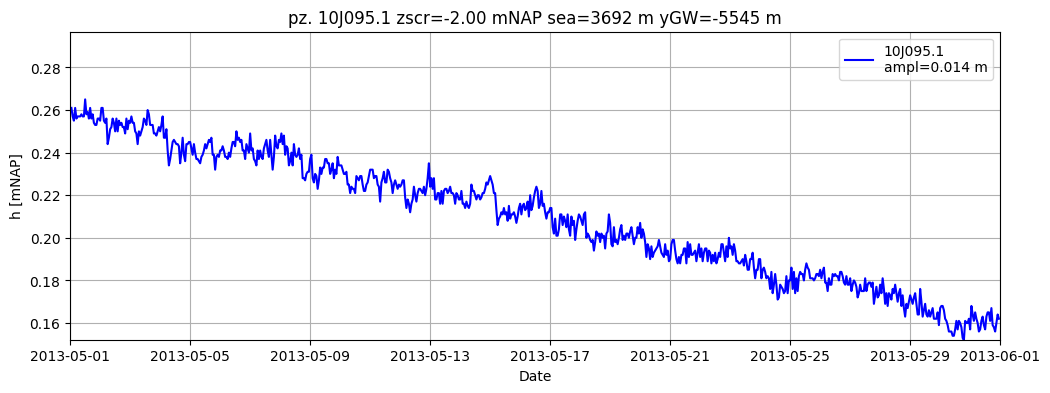

[4036]
[4273]


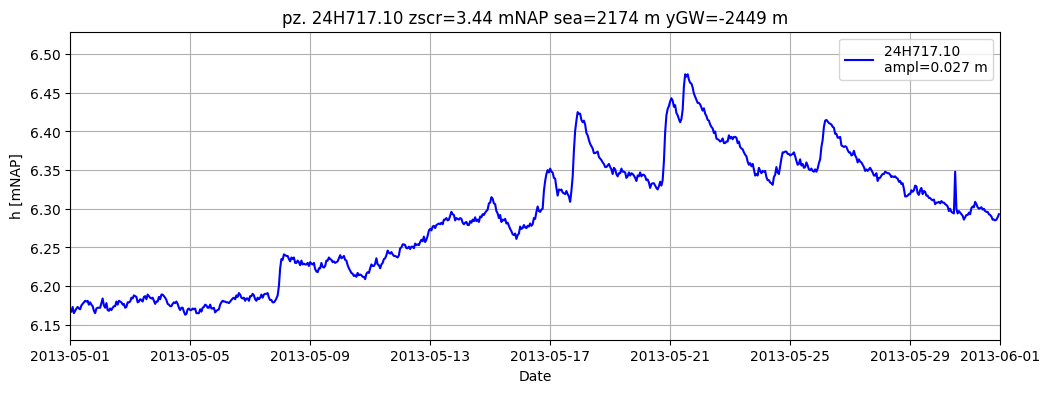

[151, 293]
[228, 356]


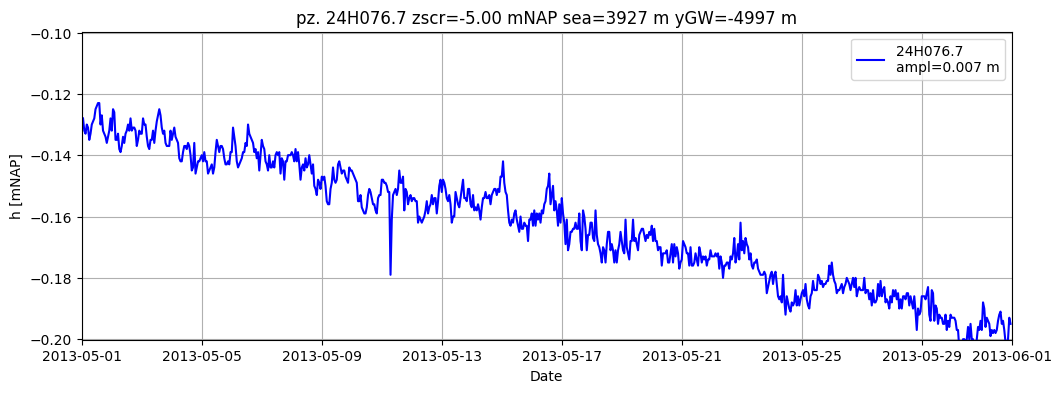

[1445]
[1813]


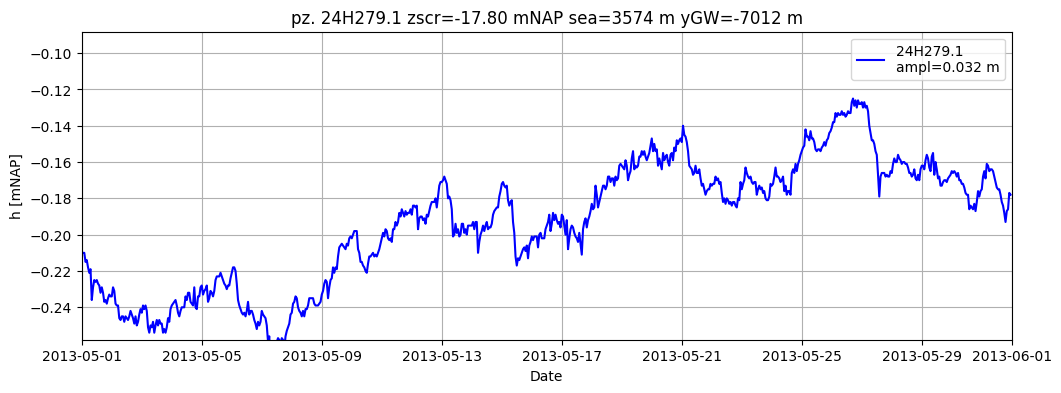

24H759.1, no peaks within tilm


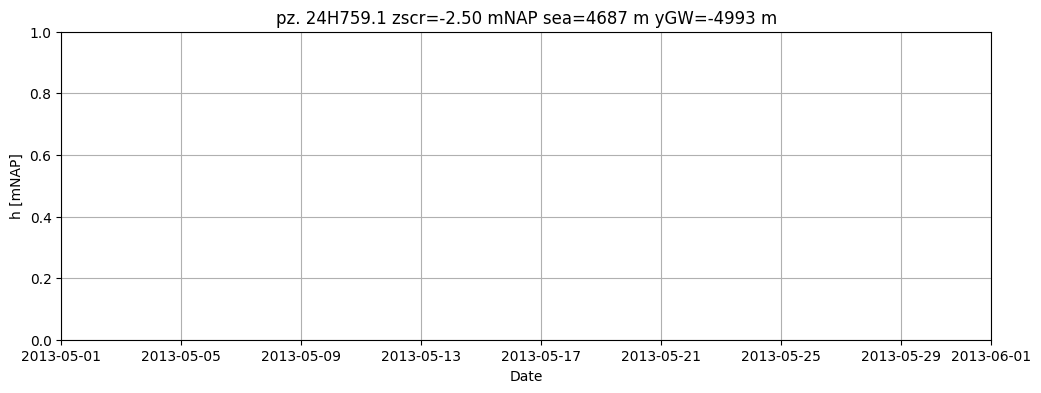

24H747.5, no peaks within tilm


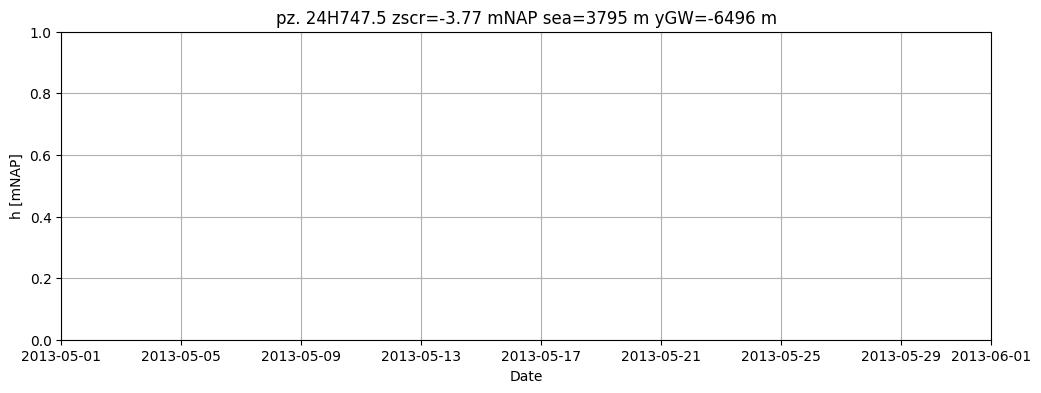

In [73]:
pzNames = ['24H717.10']

#tlim = np.datetime64('2013-05-17'), np.datetime64('2013-05-21')
#showpBuizen(pbuis, pzNames=pzNames, tlim=tlim, ylim=(0.30, 0.45))

names = ['10j094.1', '10J095.1', '24H076.7', '24H279.1', '25H759.4', '24H759.1', '24H747.5']
names = ['10J095.1', '24H717.10', '24H076.7', '24H279.1', '25H759.4', '24H759.1', '24H747.5']
names = [nm for nm in names if nm in pbuis]
print(names)

tlim = np.datetime64('2013-05-01'), np.datetime64('2013-06-01')
for pzNames in names:
    showpBuizen(pbuis, pzNames=[pzNames], tlim=tlim, ylim=None)

[81, 232, 380, 532, 680, 834, 983, 1134, 1288, 1439, 1588, 1738, 1887, 2035, 2182, 2329, 2477, 2621, 2772, 2919, 3066, 3212, 3363, 3507, 3659, 3802, 3952, 4094, 4246, 4395, 4544, 4692, 4845, 4991, 5143, 5295]
[180, 324, 483, 630, 781, 930, 1084, 1233, 1391, 1534, 1692, 1835, 1984, 2133, 2281, 2432, 2582, 2723, 2872, 3020, 3166, 3314, 3462, 3607, 3755, 3906, 4052, 4202, 4345, 4492, 4638, 4786, 4939, 5091, 5240, 5393, 5540]


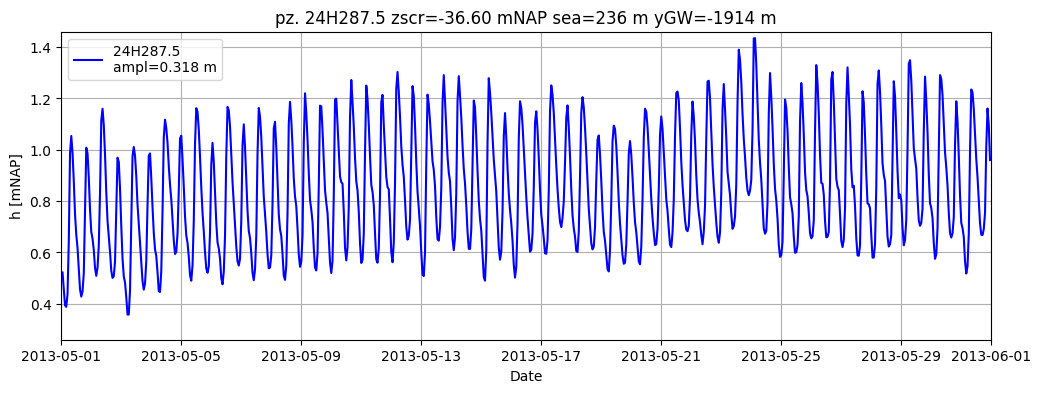

In [53]:
pzNames = ['24H258.5', '24H287.5', '24H465.4'] # '24H461.5',
pzNames = ['24H464.5', '24H287.5', '24H465.4'] # '24H461.5',
pzNames = ['24H287.5']

tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')
tlim = np.datetime64('2013-05-01'), np.datetime64('2013-06-01')
showpBuizen(pbuis, pzNames=pzNames, tlim=tlim)

[40, 191, 336, 487, 634, 780, 929, 1078, 1224, 1368, 1519, 1664, 1816]
[135, 283, 429, 580, 724, 874, 1024, 1166, 1318, 1464, 1614, 1756, 1907]
[32, 185, 330, 481, 622, 774, 918, 1067, 1216, 1364, 1512, 1657, 1807]
[129, 282, 426, 575, 719, 869, 1016, 1161, 1314, 1458, 1603, 1753, 1901]
[29, 180, 324, 474, 617, 767, 915, 1061, 1211, 1358, 1507, 1653, 1799]
[126, 277, 424, 572, 716, 867, 1014, 1158, 1312, 1457, 1600, 1748, 1899]


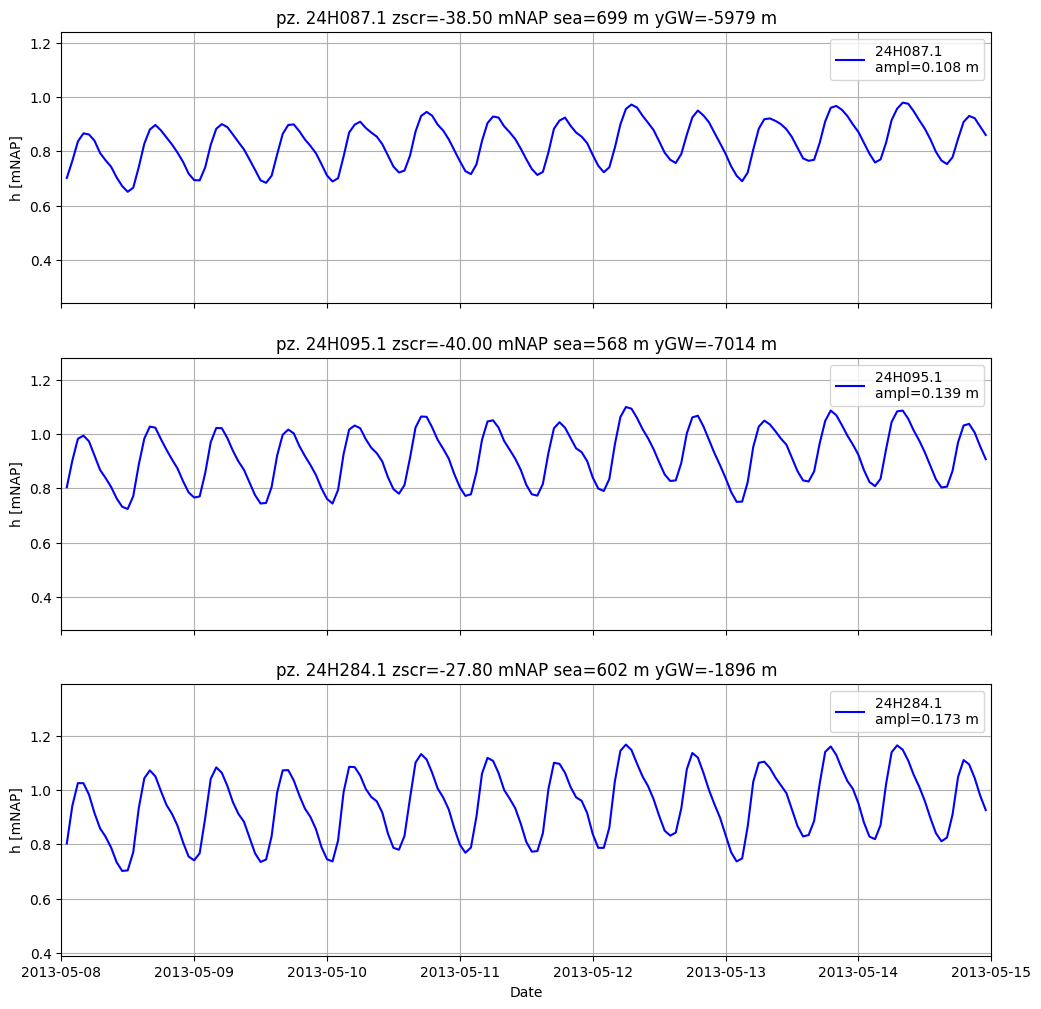

In [36]:
pzNames = ['24H087.1', '24H095.1', '24H284.1']
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')
showpBuizen(pbuis, pzNames=pzNames, tlim=tlim)

In [ ]:
pzNames = ['24H1248.4', '24H245.5', '24H453.5']
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')
showpBuizen(pbuis, pzNames=pzNames, tlim=tlim)

In [ ]:
pzNames = ['24H378.1', '24H540.4', '24H717.7']  #  '24H749.6'
tlim = np.datetime64('2013-04-01'), np.datetime64('2013-06-01')
tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')
showpBuizen(pbuis, pzNames=pzNames, tlim=tlim)

## Put series for over a short period next to each other to show tide damping as a function of distance to the sea.

In [ ]:
def showpBuizen_next_to_each_other(pbuis, pzNames=None, tlim=None, verbose=None):

    pzMissing = [nm for nm in pzNames if nm not in pbuis]
    for pz in pzMissing:
        print("{} not in pbuis dataset!".format(pzMissing))

    # Continue with the rest
    pzNames = [nm for nm in pzNames if nm in pbuis]
    
    fig, axs = plt.subplots(1, len(pzNames), sharex=True)
    fig.set_size_inches(12, 4)

    assert tlim is not None, "tlim must not be None but (tstart, tend) both np.datetime64)"
            
    for i, name in enumerate(pzNames):
        
        pb = pbuis[name]
        xRD, yRD = pb['xRD'], pb['yRD']
        xGW, yGw = rd2gw(np.array([[xRD, yRD]]))[0]
        toSea = xGW + 2000.
        
        axs[i].set_title(
            """pz. {}
            zscr={:.2f} mNAP
            sea={:.0f} m yGW={:.0f} m""".format(name, pb['okf'], toSea, yGw), fontsize=8)

        if name == pzNames[0]:
            axs[i].set_ylabel('h [mNAP]')
        axs[i].set_xlabel('Date')
            
        axs[i].grid(True)
        axs[i].set_xlim(tlim)
        axs[i].tick_params(which='major', labelrotation=45)

        tml = pb['values'][:, 0]
        tnp = dn2dt(tml)
        L = np.logical_and(tnp > tlim[0], tnp < tlim[1])
        h = pb['values'][:, 1]
        if len(h[L]) == 0:
            print("{}, no peaks within tilm".format(name))
            continue
        
        interpolator = CubicSpline(tml[L], h[L] - h[L].mean())
        tml5m = np.arange(tml[L][0], tml[L][-1] + 1 / (60 * 24), 5 / (60 * 24))            
        h5m = interpolator(tml5m)
        I, J = peak_indices(t=tml5m, h=h5m, verbose=verbose)

        amplitude = np.median(h5m[I] - h5m[J])/2

        axs[i].plot(tnp[L], h[L], 'blue', label="{}\nampl={:.3f} m".format(name, amplitude))

        m = np.round(h.mean(), 2)
        axs[i].set_ylim(m - 0.5, m + 0.5)
        axs[i].legend(loc='best', fontsize=8)

    fig.savefig("tijdeAmpl" + pzNames[0][:-2] + ".png")
        
    plt.show()
    return

pbSeries = [
    ['24H' + n for n in ['258.5', '075.1', '072.1', '1248.4', '373.1', '378.1']], # '464.5', 
    ['24H' + n for n in ['287.5', '284.1', '597.7', '717.7']],
    ['24H' + n for n in ['075.1', '072.1', '453.5']]]

tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-11')
for pzNames in pbSeries:
    showpBuizen_next_to_each_other(pbuis, pzNames=pzNames,  tlim=tlim, verbose=False)

# Try to capture the delay by plotting the curves on the same scale

# Experiment with peaks

In [ ]:
def showpBuizen_on_top_of_each_other(pbuis, pzNames=None, tlim=None, verbose=False):

    for name in pzNames:
        assert name in pbuis.keys(), "Name {} not in pbuis.".format(name)
    
    fig, ax = plt.subplots(1, 1, sharex=True)
    fig.set_size_inches(12, 4)
    ax.set_title("""Tides in wells Amsterdam Water Supply Dunes, May 2013, (h - mean(h)) [m]""")
    ax.set_ylabel('h - mean(h) [m]')
    ax.set_xlabel('Date')
    ax.grid(True)

    if tlim is None:
        tlim = np.array([np.datetime64('2013-04-01'), np.datetime64('2013-13-01')])

    ax.set_xlim(tlim)
    
    for name in pzNames:
        
        pb = pbuis[name]
        xRD, yRD = pb['xRD'], pb['yRD']
        xGW, yGW = rd2gw(np.array([[xRD, yRD]]))[0]
        toSea = xGW + 2000.
        
        tml = pb['values'][:, 0]
        h = pb['values'][:, 1]        

        tnp = dn2dt(tml)
        L = np.logical_and(tnp > tlim[0], tnp <= tlim[1])        

        if verbose:
            print("Time points within tlim == {}".format(L.sum()))
                
        if len(h) == 0 or L.sum() == 0:
            if verbose:
                print("{}, nodata within tlim (len(h) == 0)".format(name, L.sum()))
            continue
        
        interpolator = CubicSpline(tml[L], h[L] - h[L].mean())

        ax.plot(tnp[L], h[L] - h[L].mean(), label="{:8s}, yGW={:4.0f}, m, tosea={:4.0f} m".format(name, yGW, toSea))

        # Use interpolated 5min dist time series              
        tml5m = np.arange(tml[L][0], tml[L][-1] + 1 / (60 * 24), 5 / (60 * 24))            
        h5m = interpolator(tml5m)

        I, J = peak_indices(t=tml5m, h=h5m, verbose=verbose)

        ax.plot(dn2dt(tml5m[I]), h5m[I], 'ro')
        ax.plot(dn2dt(tml5m[J]), h5m[J], 'go')

        amplitude = np.median(h5m[I] - h5m[J])/2
        
        if name == pzNames[0]:
            print("Medians of\n{:10s} {:21s} {:21s} {:14s} {:14s} {:8s} {:8s} {:8s}".format(
                'piezom',
                'peaktime', 'valleytime',
                'pk_datenum', 'va_datenum',
                'amplitude', 'yGw_m', 'toSea_m'))
        print("{:10s} {:21s} {:21s} {:14.6f} {:14.6f} {:8.3f} {:8.0f} {:8.0f}".format(
                                       name,
                                       dn2dt(np.median(tml5m[I])),
                                       dn2dt(np.median(tml5m[J])),
                                       np.median(tml5m[I]),
                                       np.median(tml5m[J]),                                                                   
                                       np.median(amplitude), yGW, toSea))

        # ax.plot(dn2dt(tml5m), h5m, 'k', lw=1, label="{:8s}, yGW={:4.0f}, tosea={:4.0f} m".format(name))
    
    m = 0.0 # np.round(h.mean(), 2)
    ax.set_ylim(m - 0.5, m + 0.5)
    ax.legend(loc='best', fontsize=8)

    fig.savefig("tideAWD" + pzNames[0][:-2] + ".png", transparent=True)
        
    plt.show()
    return

tlim = np.datetime64('2013-05-08'), np.datetime64('2013-05-15')

for pzNames in [
        ['24H' + n for n in ['258.5', '464.5', '075.1', '072.1', '1248.4', '377.1', '378.1']],
        ['24H' + n for n in ['287.5', '284.1', '597.7', '717.7']],
        ['24H' + n for n in ['075.1', '072.1', '453.5']]]:
    print(pzNames)

    showpBuizen_on_top_of_each_other(pbuis, pzNames=pzNames,  tlim=tlim)